# Introduction

## 1. 프로젝트 목적

이 노트북은 "카페 주문 앱"의 1년치 사용자 행동 로그 데이터를 기반으로 데이터 구조를 이해하고, 분석에 필요한 기본 전처리 작업을 수행하는 단계이다.

이 단계의 목표는 다음과 같다.

- 전체 데이터셋 구조 파악 (Users, Menus, Events, Purchases)
- 각 데이터셋의 역할과 서로의 관계 이해
- 기본 통계 및 분포 확인
- 결측치 및 이상치 점검
- 파생 변수 생성 (예: 방문일, 요일, 구매금액 등)
- 이후 분석(퍼널, 코호트, A/B 테스트)에 활용될 형태로 데이터 정리

---

## 2. 데이터셋 설명

### (1) `users.csv`

앱을 사용하는 유저 정보. 각 유저별 성향, 디바이스, 유입 채널 등의 정보가 포함됨.

주요 컬럼
- `user_id`
- `signup_date`
- `device`
- `channel`
- `price_sensitivity`
- `impulse_level`
- `return_prob`
- `preferred_category`

---

### (2) `menus.csv`

주문 가능한 메뉴 정보

주요 컬럼
- `menu_id`
- `name`
- `category`
- `price`
- `discount_flag`

---

### (3) `events.csv`

가장 핵심이 되는 사용자 행동 로그. 유저 행동이 시간순으로 기록된 이벤트 기반 데이터셋

주요 event_type
- `AppOpen`
- `SearchMenu`
- `ViewMenu`
- `AddToCart`
- `CheckoutStart`
- `PaymentSuccess`

---

### (4) `purchases.csv`

결제 성공(PaymentSuccess) 이벤트만 추출한 구매 기록.

주요 컬럼
- `purchase_id`
- `user_id`
- `menu_id`
- `price`
- `category`
- `timestamp`
- `experiment_group`

---

## 3. 데이터 이해 단계

Data Understanding은 그로스해킹/데이터 분석의 필수 전처리 단계이다. 이 단계에서 놓치는 부분이 있으면

- 퍼널 구조 오류
- A/B 테스트 결과 왜곡
- 코호트 분석의 해석 불가능
- 파생 변수 품질 저하

등 잘못된 인사이트를 뽑게 된다.

---

## 4. 이 노트북에서 수행할 작업

### (1) 데이터셋 불러오기

CSV 파일을 모두 로드하고, 기본적인 구조를 확인한다.
> 예: 데이터 크기, 컬럼 타입, null 값 여부

### (2) 기본 통계 / 분포 파악

- price 분포
- impulse_level / price_sensitivity 분포
- 이벤트 발생량 히스토그램
- user당 세션 수

### (3) 결측치 및 이상치 탐지

- null 값 검사
- category/type 불일치
- timestamp 오류
- 음수/비정상 값 확인

### (4) 파생 변수 생성

이후 분석을 위해 필요한 변수들을 미리 생성

### (5) 분석 단위 정리

- 세션 단위 / 유저 단위 / 이벤트 단위 각각 활용 정리
- 퍼널 분석용 이벤트 전처리
- 코호트용 sign-up anchor 생성


# 실행 코드

## 1) 기본 설정 & 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

# 데이터 불러오기
users = pd.read_csv("../data/users.csv")
menus = pd.read_csv("../data/menus.csv")
events = pd.read_csv("../data/events.csv")
purchases = pd.read_csv("../data/purchases.csv")

print("데이터 로드 완료")

데이터 로드 완료


## 2) 데이터셋 기본 구조 확인

In [2]:
datasets = {
    "Users": users,
    "Menus": menus,
    "Events": events,
    "purchases": purchases,
}

for name, df in datasets.items():
    print("="*60)
    print(f"[{name}] shape=", df.shape)
    print(df.head(3))

[Users] shape= (200, 8)
  user_id signup_date   device  channel  price_sensitivity  impulse_level  \
0     AAA  2025-06-22      iOS     push              0.885          0.496   
1     AAB  2025-05-06  Android  organic              0.324          0.209   
2     AAC  2024-12-26      iOS       ad              0.036          0.003   

   return_prob preferred_category  
0        0.446             coffee  
1        0.197             coffee  
2        0.293             coffee  
[Menus] shape= (30, 5)
   menu_id           name category  price  discount_flag
0        1      Americano   coffee   2500              0
1        2     Cafe Latte   coffee   3300              0
2        3  Vanilla Latte   coffee   3800              0
[Events] shape= (150549, 10)
             timestamp user_id      session_id  event_type  menu_id   price  \
0  2024-12-01 00:10:00     AAM  AAM_20241201_1     AppOpen      NaN     NaN   
1  2024-12-01 00:10:05     AAM  AAM_20241201_1  SearchMenu      NaN     NaN   
2  202

## 3) 데이터 타입 및 결측치 확인

In [3]:
for name, df in datasets.items():
    print("="*60)
    print(f"[{name}] 데이터 타입:")
    print(df.dtypes)

    print(f"\n[{name}] 결측치:")
    print(df.isnull().sum())

[Users] 데이터 타입:
user_id                object
signup_date            object
device                 object
channel                object
price_sensitivity     float64
impulse_level         float64
return_prob           float64
preferred_category     object
dtype: object

[Users] 결측치:
user_id               0
signup_date           0
device                0
channel               0
price_sensitivity     0
impulse_level         0
return_prob           0
preferred_category    0
dtype: int64
[Menus] 데이터 타입:
menu_id           int64
name             object
category         object
price             int64
discount_flag     int64
dtype: object

[Menus] 결측치:
menu_id          0
name             0
category         0
price            0
discount_flag    0
dtype: int64
[Events] 데이터 타입:
timestamp            object
user_id              object
session_id           object
event_type           object
menu_id             float64
price               float64
category             object
experiment_group     objec

## 4) Users 데이터 탐색

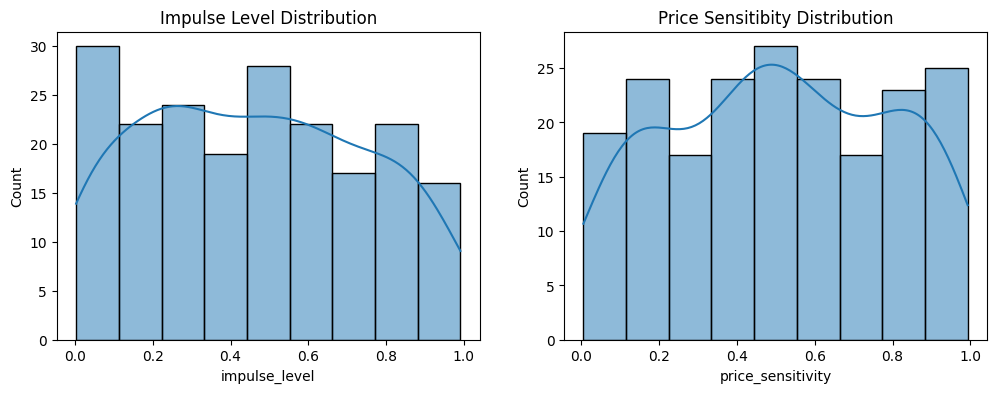

device
Android    116
iOS         84
Name: count, dtype: int64
channel
organic    107
ad          52
social      23
push        18
Name: count, dtype: int64


In [5]:
# impulse_level, price_sensitivity 분포
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(users["impulse_level"], kde=True, ax=axes[0])
sns.histplot(users["price_sensitivity"], kde=True, ax=axes[1])
axes[0].set_title("Impulse Level Distribution")
axes[1].set_title("Price Sensitibity Distribution")
plt.show()

# device / channel 비율
print(users["device"].value_counts())
print(users["channel"].value_counts())

## 5) Menus 데이터 탐색

category
coffee      10
beverage    10
dessert     10
Name: count, dtype: int64


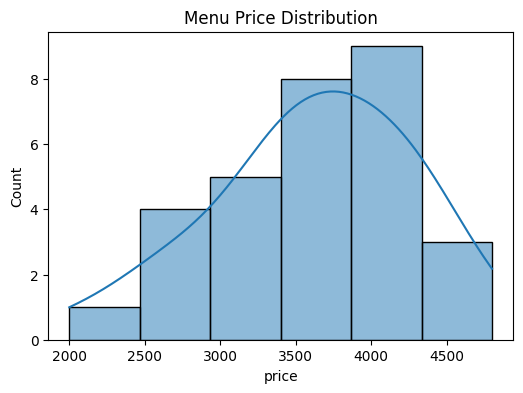

discount_flag
0    18
1    12
Name: count, dtype: int64


In [6]:
print(menus["category"].value_counts())

plt.figure(figsize=(6,4))
sns.histplot(menus["price"], kde=True)
plt.title("Menu Price Distribution")
plt.show()

print(menus["discount_flag"].value_counts())

## 6) Events 데이터 탐색

event_type
ViewMenu          73130
AppOpen           29210
SearchMenu        20440
AddToCart         16576
CheckoutStart      9184
PaymentSuccess     2009
Name: count, dtype: int64


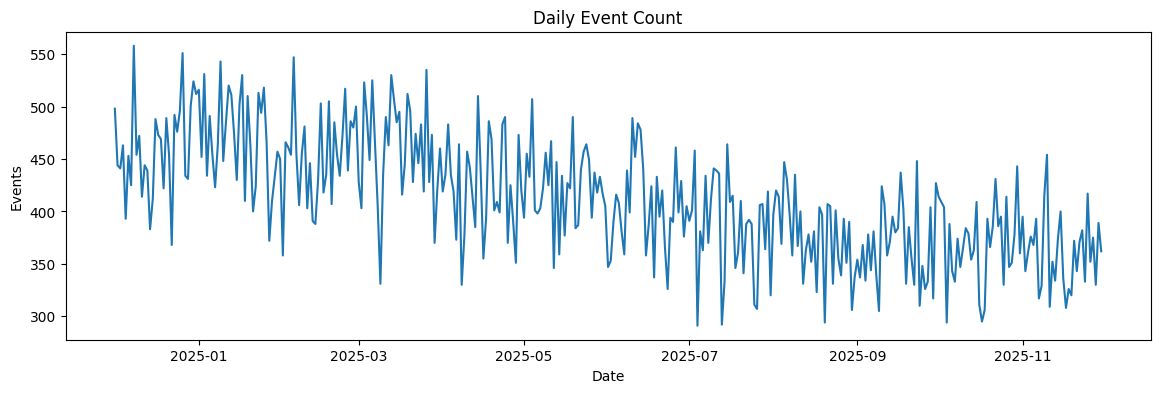

,event_type,event_hour
0,AppOpen,0
1,SearchMenu,0
2,ViewMenu,0
3,ViewMenu,0
4,AppOpen,0


In [7]:
print(events["event_type"].value_counts())

# Timestamp를 datetime으로 변환
events["timestamp"] = pd.to_datetime(events["timestamp"])

# 날짜 컬럼 추가
events["event_date"] = events["timestamp"].dt.date
events["event_hour"] = events["timestamp"].dt.hour

# 일별 이벤트 수
daily_events = events.groupby("event_date").size()

plt.figure(figsize=(14, 4))
daily_events.plot()
plt.title("Daily Event Count")
plt.xlabel("Date")
plt.ylabel("Events")
plt.show()

events[["event_type", "event_hour"]].head()

## 7) 세션 분석(기초)

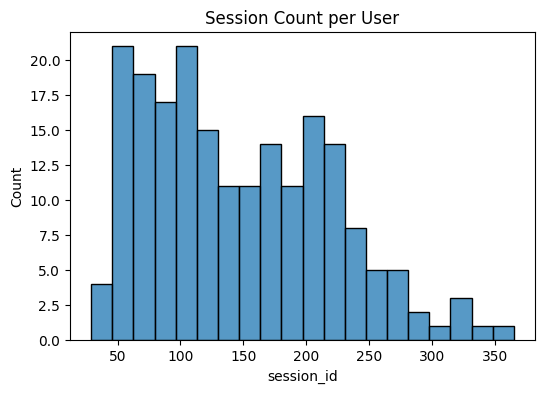

평균 세션 수: 146.05


In [8]:
# 유저별 세션 수
session_count = events.groupby("user_id")["session_id"].nunique()

plt.figure(figsize=(6,4))
sns.histplot(session_count, bins=20)
plt.title("Session Count per User")
plt.show()

print("평균 세션 수:", session_count.mean())

## 8) Purchaeses 데이터 탐색

전체 구매 건수: 2009
   purchase_id            timestamp user_id  menu_id   price  category  \
0            1  2024-12-01 01:09:52     AGD     12.0  3500.0  beverage   
1            2  2024-12-01 07:09:07     ABQ      6.0  3600.0    coffee   
2            3  2024-12-01 12:17:06     AHN      3.0  3800.0    coffee   
3            4  2024-12-01 20:02:52     AAG     17.0  4300.0  beverage   
4            5  2024-12-01 21:11:09     AFU     19.0  3800.0  beverage   

  experiment_group   device  channel  
0                A  Android  organic  
1                A  Android   social  
2                B      iOS       ad  
3                A  Android       ad  
4                B      iOS     push  


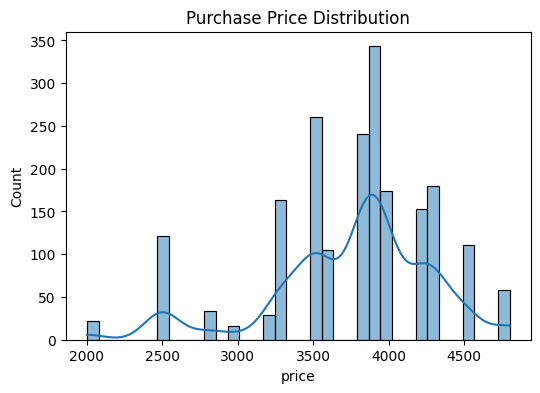

category
coffee      1162
beverage     550
dessert      297
Name: count, dtype: int64


In [9]:
print("전체 구매 건수:", len(purchases))
print(purchases.head())

# 가격 분포
plt.figure(figsize=(6,4))
sns.histplot(purchases["price"], kde=True)
plt.title("Purchase Price Distribution")
plt.show()

# 구매 메뉴 카테고리
print(purchases["category"].value_counts())

## 9) 파생 변수 생성

In [10]:
# 이벤트 기반 파생 변수
events["weekday"] = events["timestamp"].dt.weekday
events["hour"] = events["timestamp"].dt.hour

# 구매 데이터에서 날짜/요일 추가
purchases["timestamp"] = pd.to_datetime(purchases["timestamp"])
purchases["event_date"] = purchases["timestamp"].dt.date
purchases["weekday"] = purchases["timestamp"].dt.weekday

# 유저 가입 월 (cohort 용)
users["signup_date"] = pd.to_datetime(users["signup_date"])
users["signup_month"] = users["signup_date"].dt.to_period("M")

## 10) 전처리된 데이터 저장

In [11]:
events.to_csv("../data/events_prepared.csv", index=False, encoding="utf-8-sig")
purchases.to_csv("../data/purchases_prepared.csv", index=False, encoding="utf-8-sig")

print("전처리된 데이터 저장 완료")

전처리된 데이터 저장 완료
